In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from lauztat.parameters import POI
from lauztat.hypotests import Discovery
from lauztat.calculators import AsymptoticCalculator
from lauztat.config import Config

In [2]:
import tensorflow as tf
import zfit
from zfit import ztf

## Signal + background fit:

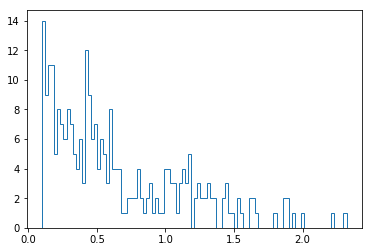

In [3]:
bounds = (0.1, 3.0)

# Data and signal

np.random.seed(0)
tau = -2.0
beta = -1/tau
data = np.random.exponential(beta, 300)
peak = np.random.normal(1.2, 0.1, 25)
data = np.concatenate((data,peak))
data = data[(data > bounds[0]) & (data < bounds[1])]

plt.hist(data, bins=100, histtype='step');

In [4]:
obs = zfit.Space('x', limits=bounds)

In [5]:
mean = zfit.Parameter("mean", 1.2, 0.1, 2., floating=False)
sigma = zfit.Parameter("sigma", 0.1, floating=False)
lambda_ = zfit.Parameter("lambda",-2.0, -4.0, -1.0)
Nsig = zfit.Parameter("Nsig", 20., -20., len(data))
Nbkg = zfit.Parameter("Nbkg", len(data), 0., len(data)*1.1)

In [6]:
signal = Nsig * zfit.pdf.Gauss(obs=obs, mu=mean, sigma=sigma)
background =  Nbkg * zfit.pdf.Exponential(obs=obs, lambda_=lambda_)
tot_model = signal + background

In [7]:
# Create the negative log likelihood
from zfit.core.loss import ExtendedUnbinnedNLL, UnbinnedNLL
data_ = zfit.data.Data.from_numpy(obs=obs, array=data)
nll = ExtendedUnbinnedNLL(model=[tot_model], data=[data_], fit_range=[obs]) 

In [8]:
# Load and instantiate a tensorflow minimizer
from zfit.minimizers.minimizer_minuit import MinuitMinimizer
minimizer = MinuitMinimizer()

In [9]:
# Create the minimization graph to minimize mu and sigma and run it (minimize does it directly)
minimum = minimizer.minimize(loss=nll)

FCN = -1145.206731390898 
 TOTAL NCALL = 70 
 NCALLS = 70 
 
 
 EDM = 2.0737526100885202e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,lambda,-1.93315,0.1408,,,-4,-1,No
1,Nbkg,251.519,16.7539,,,0,298.1,No
2,Nsig,19.4765,7.12567,,,-20,271,No


In [10]:
def plotfitresult(pdf, bounds, nbins, data):
    x = np.linspace(*bounds, num=1000)
    pdf = zfit.run(tot_model.pdf(x, norm_range=bounds))
    _ = plt.plot(x, ((bounds[1] - bounds[0])/nbins)*(pdf), "-r")

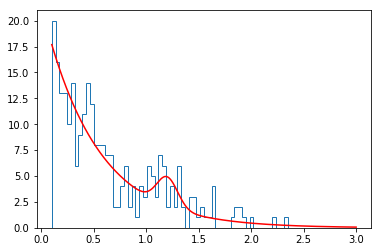

In [11]:
nbins = 80
plt.hist(data, bins=nbins, histtype='step', range=bounds);
plotfitresult(tot_model, bounds, nbins, data)

## Discovery significance.

In [12]:
def lossbuilder(model, data, weights=None):
    loss = ExtendedUnbinnedNLL(model=model, data=data, fit_range=[obs]) 
    return loss
    
config = Config(tot_model, data_, lossbuilder, MinuitMinimizer())

In [13]:
config.bestfit

Get fit best values!


FCN = -1145.2067314770634 
 TOTAL NCALL = 36 
 NCALLS = 36 
 
 
 EDM = 1.9874726930147167e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,lambda,-1.93314,0.140798,,,-4,-1,No
1,Nbkg,251.519,16.7586,,,0,298.1,No
2,Nsig,19.4765,7.1254,,,-20,271,No


In [14]:
calc = AsymptoticCalculator(config)

In [15]:
poinull = POI(Nsig, value=0)
discovery_test = Discovery(poinull, calc)

In [17]:
r = discovery_test.result();
r

Compute qobs for the null hypothesis!

p_value for the Null hypothesis = 0.0007571045219983974
Significance = 3.171946490372666


{'pnull': 0.0007571045219983974, 'significance': 3.171946490372666}